# Final Project pt. 2

In this notebook we'll attempt to predict genre(s) based on simple plot summaries.
We begin by configuring our notebook, installing the packages we'll be using, and import our dataset (which is now a slightly modified version of the final dataframe used in the previous notebook, I had to manually clean the JSON like fields in order to get this one to work):

Also, I'd like to call out that the basis for the methodolgy used below comes from a blog post at analyticsvidhya.com (a highly reputable blog on data science and visualization). The blog post can be found here: https://www.analyticsvidhya.com/blog/2019/04/predicting-movie-genres-nlp-multi-label-classification/

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
import re
import json
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('movies_1990_two.csv')

In [3]:
df.sample(5)

,budget,genres,homepage,id,keywords,overview,production_companies,release_date,revenue,runtime,...,Western,History,War,TV Movie,Foreign,year_int,buying_power,revenue_adj,budget_adj,primary_genre
2057,14000000,"{""18"": ""Drama"", ""10749"": ""Romance""}",NaN,28029,"[{""id"": 596, ""name"": ""adultery""}, {""id"": 6447,...",The world of a young housewife is turned upsid...,"[{""name"": ""Miramax Films"", ""id"": 14}, {""name"":...",1/29/99,0,107,...,0,0,0,0,0,1999,1.274675,0,17845447.59,Drama
2413,0,"{""18"": ""Drama"", ""10749"": ""Romance""}",NaN,14054,"[{""id"": 236, ""name"": ""suicide""}, {""id"": 894, ""...",Waitress Annie has separated from her suicidal...,"[{""name"": ""Crossroads Films"", ""id"": 3058}]",3/7/08,414404,106,...,0,0,0,0,0,2008,1.647307,682650.5309,0,Drama
3062,13000000,"{""27"": ""Horror"", ""53"": ""Thriller""}",http://theconjuring.warnerbros.com,138843,"[{""id"": 1156, ""name"": ""sister sister relations...",Paranormal investigators Ed and Lorraine Warre...,"[{""name"": ""New Line Cinema"", ""id"": 12}, {""name...",7/18/13,318000141,112,...,0,0,0,0,0,2013,1.782379,566796930.7,23170933.44,Horror
327,61000000,"{""28"": ""Action"", ""18"": ""Drama"", ""9648"": ""Myste...",http://www.shootermovie.com/,7485,"[{""id"": 417, ""name"": ""corruption""}, {""id"": 158...",A marksman living in exile is coaxed back into...,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...",3/22/07,95696996,124,...,0,0,0,0,0,2007,1.586396,151813363,96770175.95,Action
2999,0,"{""27"": ""Horror""}",http://www.zmdthemovie.com/,34592,"[{""id"": 7856, ""name"": ""racist""}, {""id"": 11001,...",An idyllic island town is under attack by that...,"[{""name"": ""Splendid Film"", ""id"": 8146}]",1/1/09,0,92,...,0,0,0,0,0,2009,1.641446,0,0,Horror


We'll use the following JSON funcion to create a new field containing properly formatted genres:

In [7]:
genre_list = [] 

# extract genres
for i in df['genres']: 
  genre_list.append(list(json.loads(i).values())) 

# add to 'movies' dataframe  
df['genres_new'] = genre_list

In [8]:
df.head(5)

,budget,genres,homepage,id,keywords,overview,production_companies,release_date,revenue,runtime,...,History,War,TV Movie,Foreign,year_int,buying_power,revenue_adj,budget_adj,primary_genre,genres_new
0,70000000,"{""28"": ""Action"", ""53"": ""Thriller""}",NaN,1573,"[{""id"": 502, ""name"": ""ambush""}, {""id"": 720, ""n...",John McClane is an off-duty cop gripped with a...,"[{""name"": ""Twentieth Century Fox Film Corporat...",7/2/90,240031094,124,...,0,0,0,0,1990,1.0,240031094,70000000,Action,"[Action, Thriller]"
1,49000000,"{""28"": ""Action"", ""35"": ""Comedy"", ""53"": ""Thrill...",NaN,9548,"[{""id"": 578, ""name"": ""rock and roll""}, {""id"": ...","Ford ""Mr. Rock n' Roll Detective"" Fairlane is ...","[{""name"": ""Twentieth Century Fox Film Corporat...",7/11/90,20423389,104,...,0,0,0,0,1990,1.0,20423389,49000000,Action,"[Action, Comedy, Thriller, Crime, Mystery]"
2,65000000,"{""28"": ""Action"", ""12"": ""Adventure"", ""878"": ""Sc...",NaN,861,"[{""id"": 560, ""name"": ""oxygen""}, {""id"": 769, ""n...",Construction worker Douglas Quaid discovers a ...,"[{""name"": ""TriStar Pictures"", ""id"": 559}, {""na...",6/1/90,261317921,113,...,0,0,0,0,1990,1.0,261317921,65000000,Action,"[Action, Adventure, Science Fiction]"
3,11000000,"{""28"": ""Action"", ""27"": ""Horror""}",NaN,9362,"[{""id"": 1197, ""name"": ""nevada""}, {""id"": 1415, ...",Hick handymen Val McKee and Earl Bassett can b...,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...",1/19/90,48572000,96,...,0,0,0,0,1990,1.0,48572000,11000000,Action,"[Action, Horror]"
4,30000000,"{""28"": ""Action"", ""12"": ""Adventure"", ""53"": ""Thr...",http://www.paramount.com/movies/hunt-red-october,1669,"[{""id"": 339, ""name"": ""submarine""}, {""id"": 2106...",A new Soviet nuclear missile sub (a Boomer) he...,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...",3/2/90,199200000,134,...,0,0,0,0,1990,1.0,199200000,30000000,Action,"[Action, Adventure, Thriller]"


Then we'll clean our plot summaries:

In [16]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [17]:
df['clean_overview'] = df['overview'].apply(lambda x: clean_text(x))

In [18]:
df.head(5)

,budget,genres,homepage,id,keywords,overview,production_companies,release_date,revenue,runtime,...,War,TV Movie,Foreign,year_int,buying_power,revenue_adj,budget_adj,primary_genre,genres_new,clean_overview
0,70000000,"{""28"": ""Action"", ""53"": ""Thriller""}",NaN,1573,"[{""id"": 502, ""name"": ""ambush""}, {""id"": 720, ""n...",John McClane is an off-duty cop gripped with a...,"[{""name"": ""Twentieth Century Fox Film Corporat...",7/2/90,240031094,124,...,0,0,0,1990,1.0,240031094,70000000,Action,"[Action, Thriller]",john mcclane is an off duty cop gripped with a...
1,49000000,"{""28"": ""Action"", ""35"": ""Comedy"", ""53"": ""Thrill...",NaN,9548,"[{""id"": 578, ""name"": ""rock and roll""}, {""id"": ...","Ford ""Mr. Rock n' Roll Detective"" Fairlane is ...","[{""name"": ""Twentieth Century Fox Film Corporat...",7/11/90,20423389,104,...,0,0,0,1990,1.0,20423389,49000000,Action,"[Action, Comedy, Thriller, Crime, Mystery]",ford mr rock n roll detective fairlane is expe...
2,65000000,"{""28"": ""Action"", ""12"": ""Adventure"", ""878"": ""Sc...",NaN,861,"[{""id"": 560, ""name"": ""oxygen""}, {""id"": 769, ""n...",Construction worker Douglas Quaid discovers a ...,"[{""name"": ""TriStar Pictures"", ""id"": 559}, {""na...",6/1/90,261317921,113,...,0,0,0,1990,1.0,261317921,65000000,Action,"[Action, Adventure, Science Fiction]",construction worker douglas quaid discovers a ...
3,11000000,"{""28"": ""Action"", ""27"": ""Horror""}",NaN,9362,"[{""id"": 1197, ""name"": ""nevada""}, {""id"": 1415, ...",Hick handymen Val McKee and Earl Bassett can b...,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...",1/19/90,48572000,96,...,0,0,0,1990,1.0,48572000,11000000,Action,"[Action, Horror]",hick handymen val mckee and earl bassett can b...
4,30000000,"{""28"": ""Action"", ""12"": ""Adventure"", ""53"": ""Thr...",http://www.paramount.com/movies/hunt-red-october,1669,"[{""id"": 339, ""name"": ""submarine""}, {""id"": 2106...",A new Soviet nuclear missile sub (a Boomer) he...,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...",3/2/90,199200000,134,...,0,0,0,1990,1.0,199200000,30000000,Action,"[Action, Adventure, Thriller]",a new soviet nuclear missile sub a boomer head...


Next, we'll examine the most commonly occuring words in the dataset:

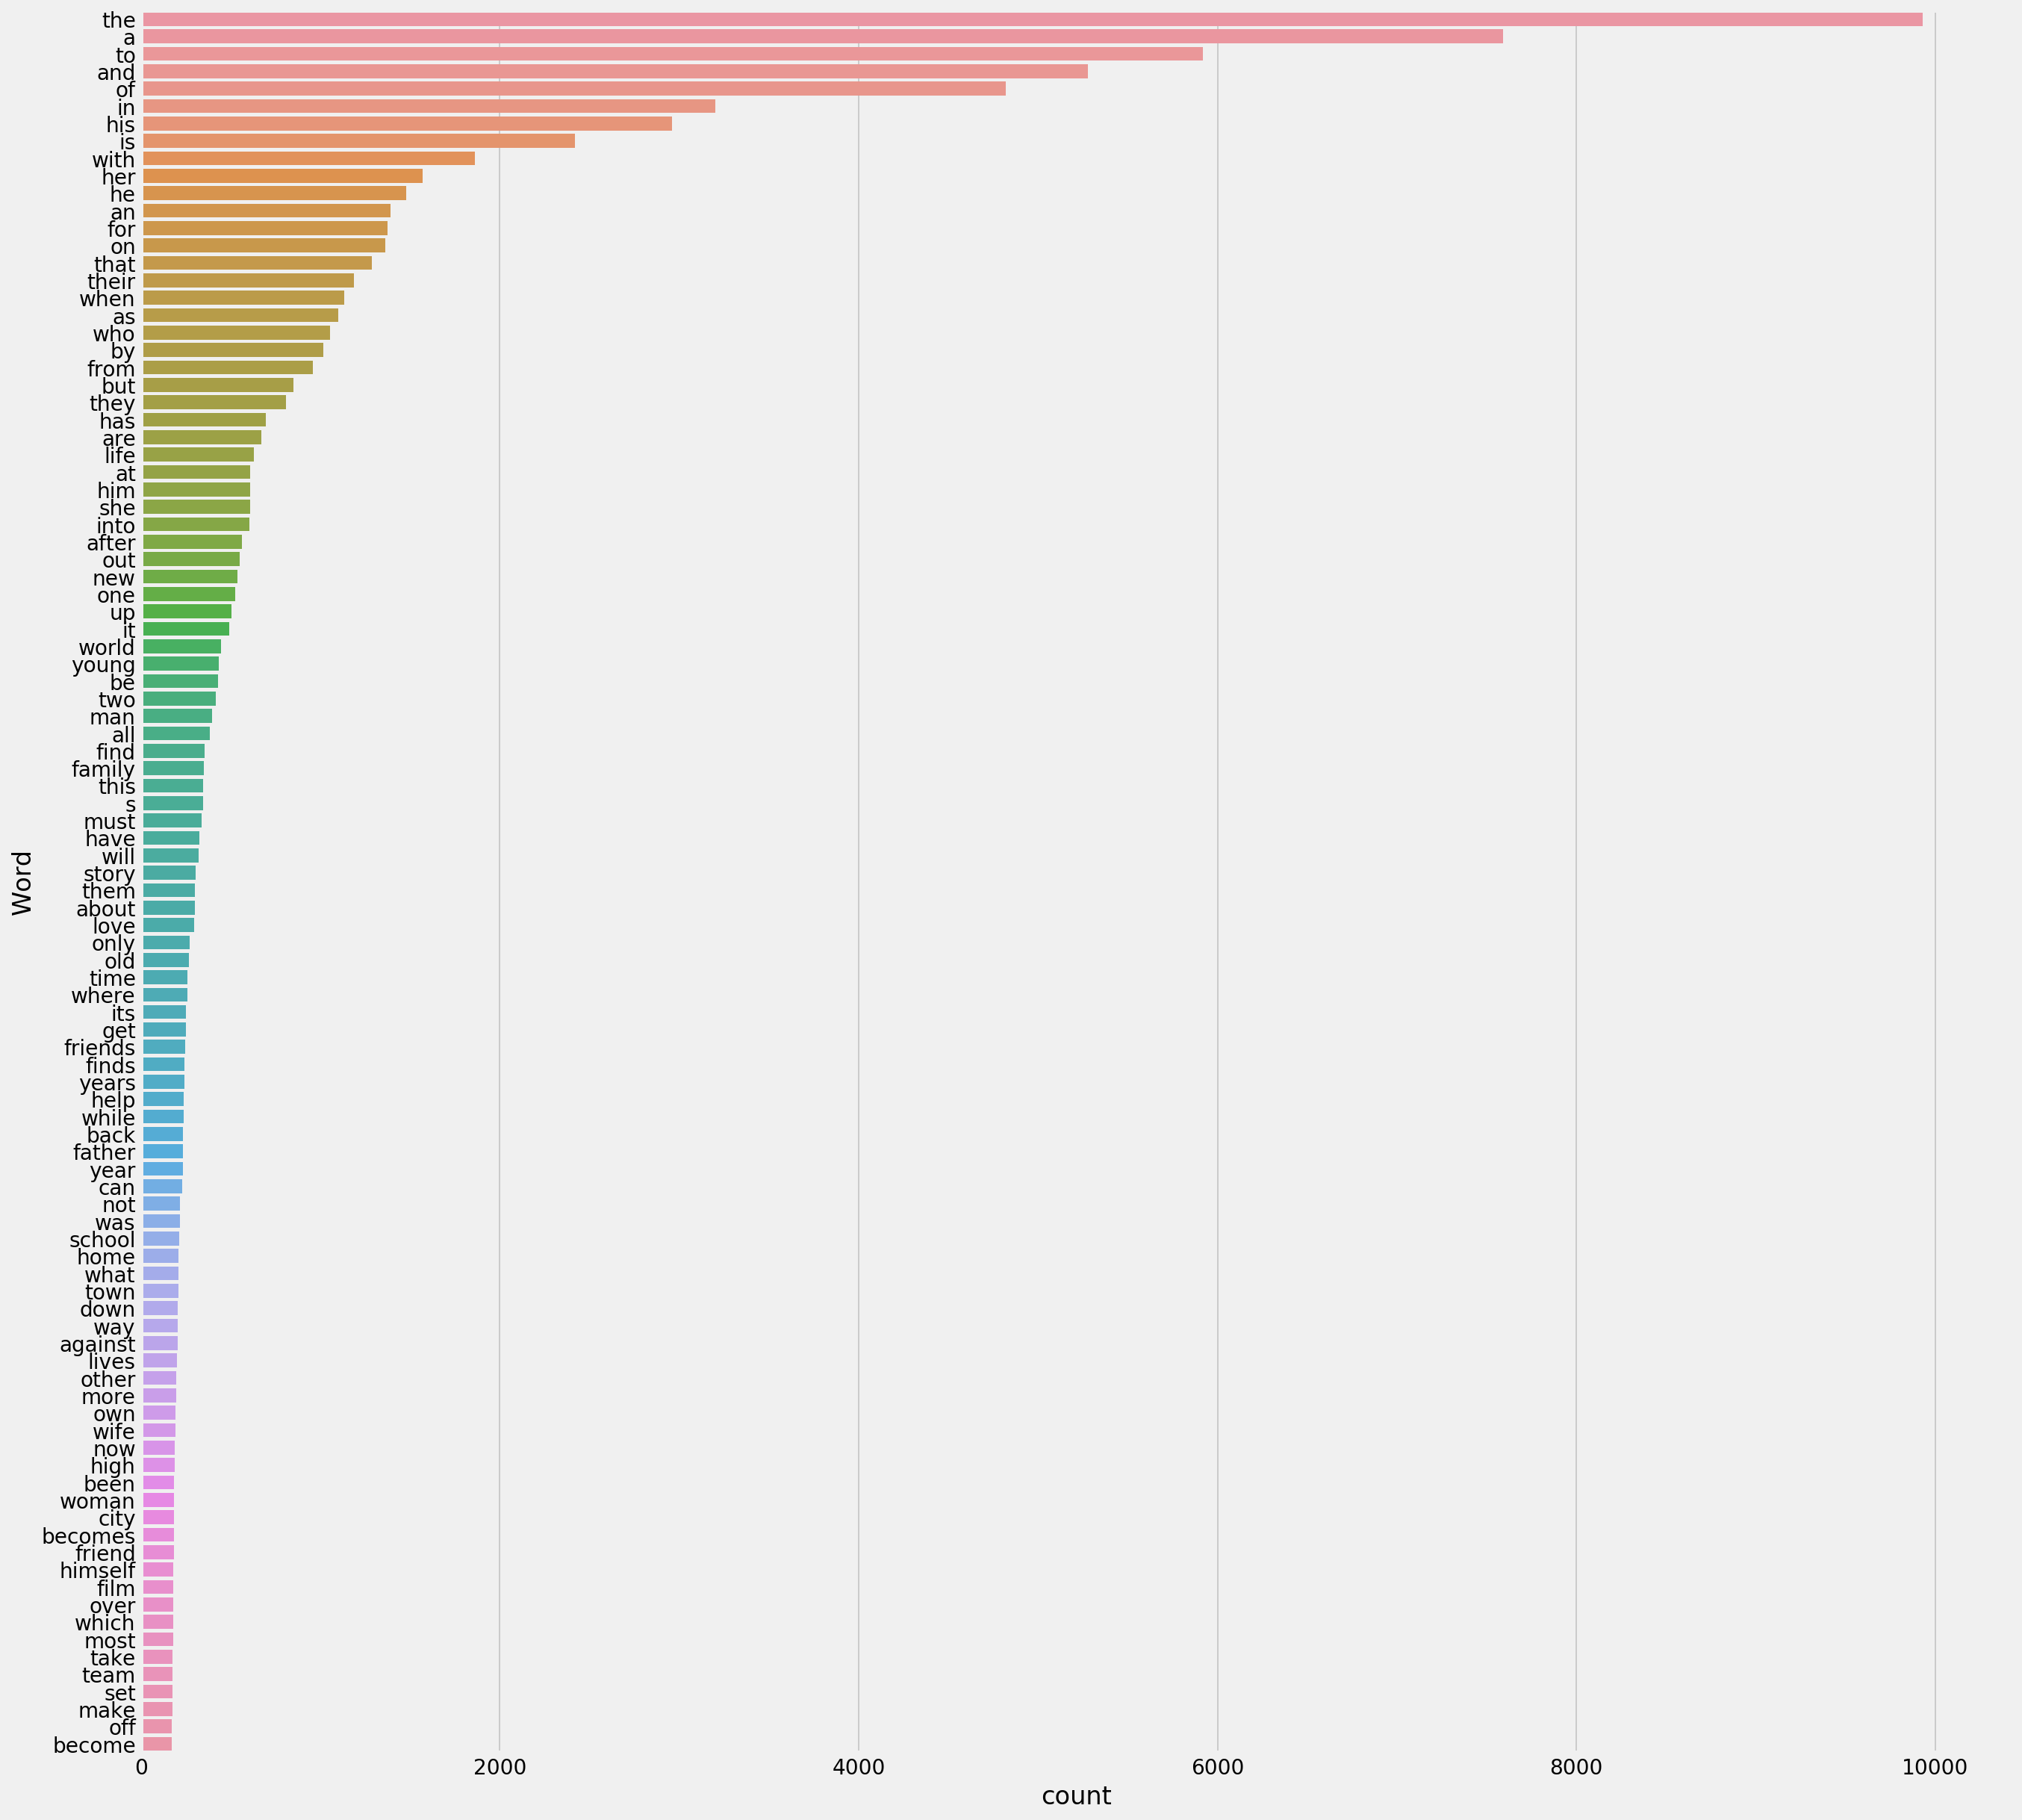

In [19]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(20,20)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(df['clean_overview'], 100)

Most of these words are super generic so we'll download "stopwords" to remove them, then examine the new graph with stopwords removed:

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jstabinsky/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

df['clean_overview'] = df['clean_overview'].apply(lambda x: remove_stopwords(x))

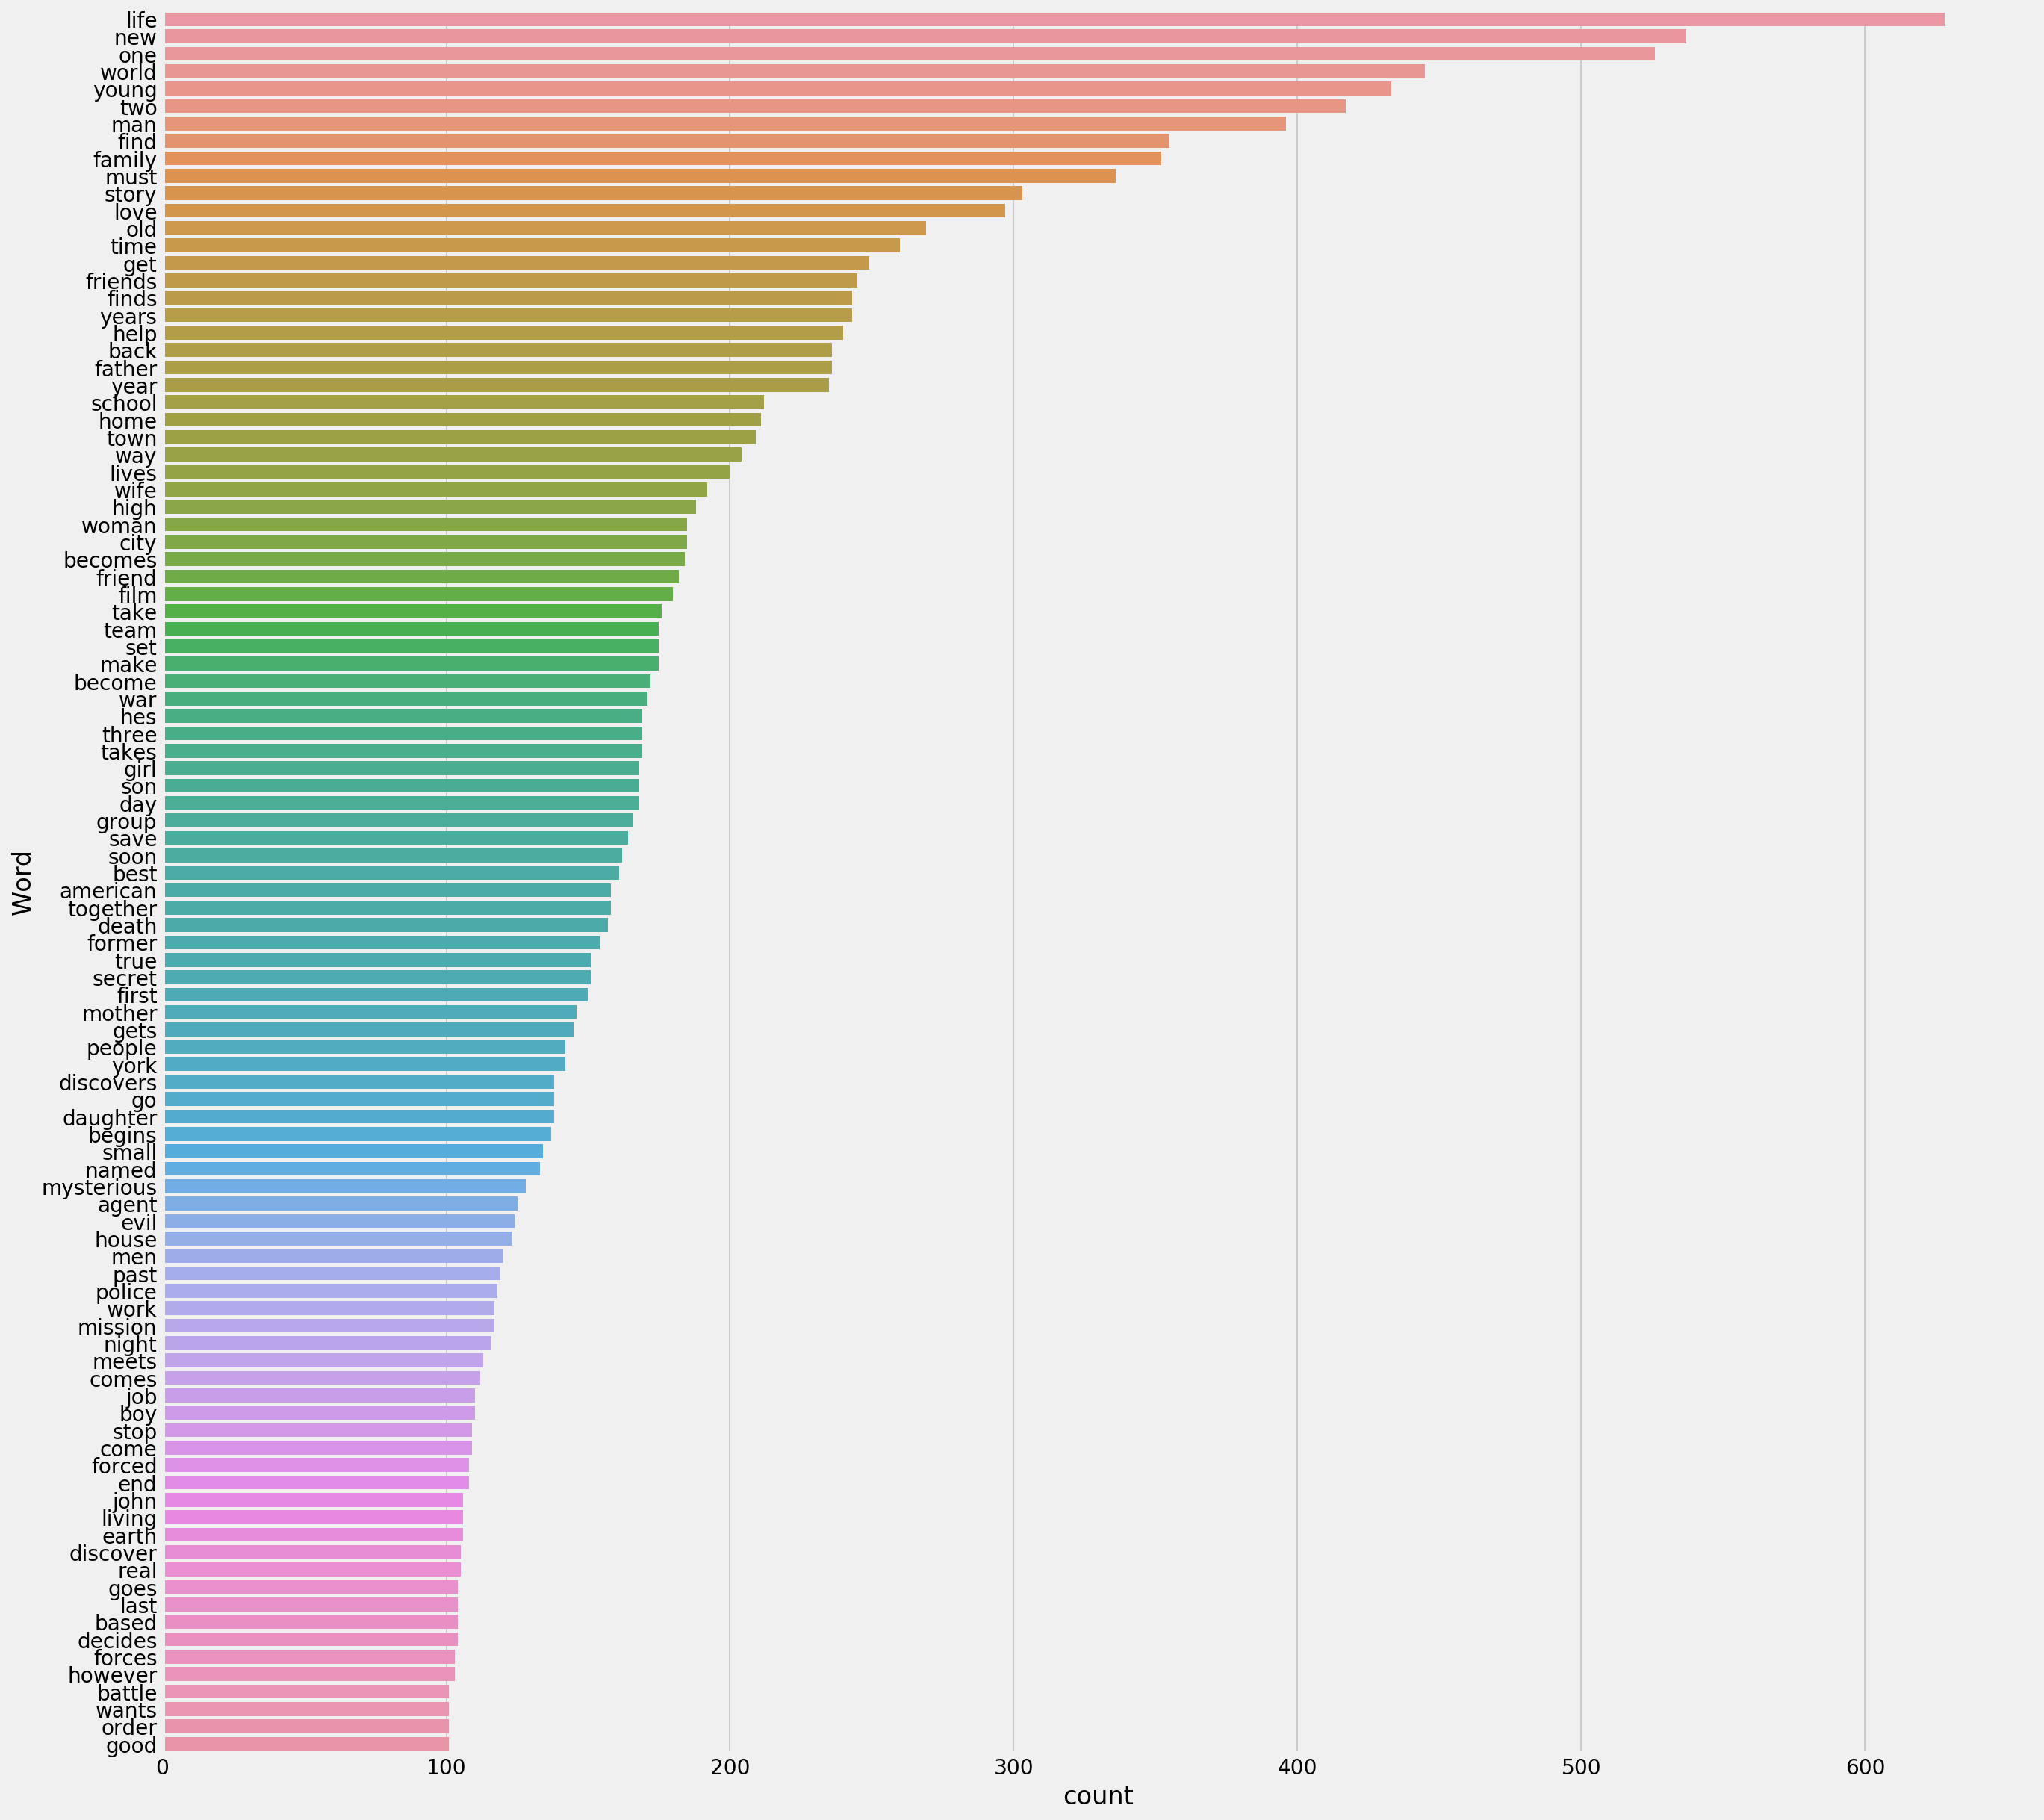

In [23]:
freq_words(df['clean_overview'], 100)

Finally, we'll assemble our model which utilizes the 10,000 most frequently occuring words as our feature. We're effectively determining which words are most commonly associated with each genre. Our default for predicting a genre is initially set at 50+% confidence, but we'll later see that the model can be more accurate with a lower threshold:

In [24]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['genres_new'])

# transform target variable
y = multilabel_binarizer.transform(df['genres_new'])

In [27]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [30]:
xtrain, xval, ytrain, yval = train_test_split(df['clean_overview'], y, test_size=0.2, random_state=10)

In [31]:
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [32]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [33]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 16 is present in all training examples.
  str(classes[c]))


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [34]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

We'll check the prediction for a random cell, in this case, it's predicting the film is a Crime and a Thriller:

In [36]:
y_pred[102]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [37]:
multilabel_binarizer.inverse_transform(y_pred)[102]

('Crime', 'Thriller')

Next, we'll check our F Score which is unfortunately pretty low at first (.305)

In [504]:
# evaluate performance
f1_score(yval, y_pred, average="micro")

0.30541012216404884

Instead of using a firing threshold of 50%, we can test out various other thresholds and see what returns the most accurate model. We ultimately find that a threshold of 20% gives us the most accurate model with an F Score of .537:

In [38]:
y_pred_prob = clf.predict_proba(xval_tfidf)

In [39]:
#testing a new threshold value
t = 0.3
y_pred_new = (y_pred_prob >= t).astype(int)

In [40]:
f1_score(yval, y_pred_new, average="micro")

0.5367215861491205

In [41]:
t_list = [.1, .2, .3, .4, .5, .6, .7, .8, .9]

for t_value in t_list:
    t = t_value # threshold value
    y_pred_new = (y_pred_prob >= t).astype(int)
    print('f1 score when threshold =', t_value, '--', f1_score(yval, y_pred_new, average="micro"))

f1 score when threshold = 0.1 -- 0.4296315583908345
f1 score when threshold = 0.2 -- 0.5448103376406837
f1 score when threshold = 0.3 -- 0.5367215861491205
f1 score when threshold = 0.4 -- 0.4566371681415929
f1 score when threshold = 0.5 -- 0.30541012216404884
f1 score when threshold = 0.6 -- 0.13883299798792756
f1 score when threshold = 0.7 -- 0.0416221985058698
f1 score when threshold = 0.8 -- 0.006535947712418301
f1 score when threshold = 0.9 -- 0.0


/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


We can test the accuracy of our original threshold and the new threshold on another random cell:

In [43]:
t = 0.2 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

In [44]:
y_pred_new[2]

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0])

In [45]:
y_pred[2]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [46]:
yval[2]

array([0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [47]:
multilabel_binarizer.inverse_transform(yval)[2]

('Comedy', 'Drama', 'Family', 'Romance')

In [48]:
multilabel_binarizer.inverse_transform(y_pred)[2]

('Comedy',)

In [49]:
multilabel_binarizer.inverse_transform(y_pred_new)[2]

('Comedy', 'Drama', 'Romance', 'Thriller')

We see that the prediction from y_pred_new is far more accurate than that of the original y_pred. An F Score of .53 is not phenomenal by any means though. In order to dig a little deaper we can examine the precision specifically which turns out to be super low (.21):

In [50]:
average_precision = average_precision_score(yval, y_pred_new)
print(average_precision)

0.2179828249767594


Ultimately, we were successful in getting two models to run that help answer both of the original questions. Unfortunately the models could be far more accurate. There are a number of next steps I would take which I have laid out in my final presentation.